### Simple Gaussian Processes Regression example

Here you can find a small example of how to code your GP regression from scratch using squared exponential covariance function and
Sampling functions from the join probability distribution of GP given only the choice of covariance function. Covariance function determines how much correlation are there between inputs points. 

My inspiration (http://katbailey.github.io/post/gaussian-processes-for-dummies/)

### Squared exponential

$$k(x,y) = s*\mathrm{exp}(-\frac{(x-y)^2}{2l^2})$$

$l$ - length scale
$s$ - signal variance

If the length scale parameter is small, the covariance of the parameters should be small and thus parameters are kinda tight to each other and the curve is spiky.
If the length scale parameter is big, the covariance is big and thus parameters are more independent


## How to think about GP so that it doesn't seem like a nightmare.

GP is a collection of functions specified by mean and covariance functions. By specifying these two functions, we can already sample functions for GP. 
_Sampling a function_ means that we get an estimate or guess how the function may look like that will describe the given data (points). Adding training points (points with known function values) reduces the space of function, restricting only to those, which pass through the given training points. While adding the points, we update/adapt the mean and covariance function. We are doing that by computing the joined multi-dimensional Gaussian distribution. This Gaussian will have as many dimensions as a number of points in training set. 

Whenever we want to make predictions for some other points, we need to compute the joined Gaussian distribution between the points we already have (training) and testing points.

![image_name](data/gp_starting/gaussian_processes.png)

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# setting the kernel function / covariance
# here square exponential
def kernel(xi, xj, l, signal_var):
    sqDist = (xi - xj)**2
    return signal_var*np.exp(-0.5*(1.0/l**2) *sqDist)

def computeCovariance(x, y, l, signal_var):
    M = len(x)
    N = len(y)
    K = np.zeros((M,N))
    for i, xi in enumerate(x):
        for j, yj in enumerate(y):
            K[i,j] = kernel(xi, yj, l, signal_var)
    return K

## samples from any gaussian using N(0,1)
#  x -> mu + sigma(N(0,1))
# N- number of points the sample function should be evaluated in
def sampleFromGaussian(mu, sigma, N):
    B = np.linalg.cholesky(sigma + 1e-9*np.eye(N))
    s = np.random.normal(0, 1, N)
    samples = mu + np.dot(B,s)
    return samples

x_test = np.linspace(-5, 5, 60)
N = len(x_test)

L = np.arange(0.5, 2.0, 0.5)
L = np.append(L,[0.01])

signal_var = 0.1

for l in L:
    # construct K** matrix
    K = computeCovariance(x_test, x_test, l, signal_var)
    mu = np.zeros(N)
    f_prior = sampleFromGaussian(mu,K, N)

    plt.plot(x_test, f_prior, '-',label=str(l))


plt.legend()
plt.title("Varying length scale l")
plt.show()

## Updating GP posterior based on training points
The parameters of the GP for the posterior distribution are updated based on training points $X$ and points for which the predictions are needed $X_*$
$$\mu(X_*) = K(X_*,X)K(X,X)^{-1}y$$
$$V(X_*) = K(X_*, X_*) - K(X_*,X)K(X,X)^{-1}K(X,X_*)$$

**Hint**: Keep in mind that xs( X_start) are only needed for visualizing the function. If you want a prediction for a point xs should be a point. But GP exists (in some high dimensional magical space also without xs, :) also without x, as a prior given a kernel function, but x constrain the space of GP)

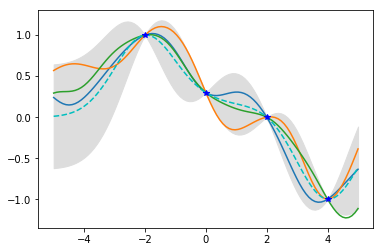

In [3]:
## adding data points
x = [-2, 0, 4, 2]
y = [1, 0.3, -1, 0]

x_test = np.linspace(-5, 5, 100)
l_a = 1.0

signal_var = 0.1
# Updating GP mean
## K(X,X)
K_xx = computeCovariance(x,x, l_a, signal_var)
## K(X*,X)
K_sx = computeCovariance(x_test, x, l_a, signal_var)
alpha = np.linalg.solve(K_xx,y)
mu_post = np.dot(K_sx, alpha)

# updating GP variance
K_ss = computeCovariance(x_test, x_test, l_a, signal_var)
V_post = K_ss - np.dot(K_sx, np.dot( np.linalg.inv(K_xx), K_sx.transpose()))

stdv = np.sqrt(np.diag(V_post))

for i in range(3):
    f_post = sampleFromGaussian(mu_post, V_post, len(x_test))
    plt.plot(x_test, f_post)
    
plt.plot(x_test, mu_post, 'c--')
plt.fill_between(x_test, mu_post - 2*stdv, mu_post + 2*stdv,color="#dddddd")
plt.plot(x, y, 'b*')
plt.show()


**Covering GP in a function. Recomputing covariance**

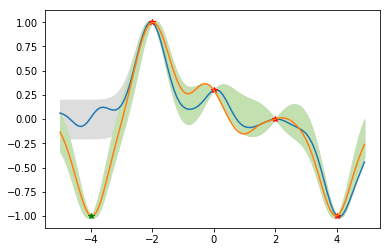

In [4]:
# x - training inputs
# y - training values
# xs - inputs to get predictions for from GP
def sampleFromGP(xs, x, y):
    l = 0.5
    sig_var = 0.01 # signal variance
    
    K_xx = computeCovariance(x, x, l, sig_var)
    K_sx = computeCovariance(xs, x, l, sig_var)
    alpha = np.linalg.solve(K_xx,y)
    mu_post = np.dot(K_sx, alpha)

    # updating GP variance
    K_ss = computeCovariance(xs, xs, l, sig_var)
    V_post = K_ss - np.dot(K_sx, np.dot( np.linalg.inv(K_xx), K_sx.transpose()))
    y_post = sampleFromGaussian(mu_post, V_post, len(xs))
    return y_post, mu_post, V_post

x = [-2, 0, 4, 2]
y = [1, 0.3, -1, 0]
x_test = np.arange(-5,5,0.1)

(y_1, mu_1, V_1) = sampleFromGP(x_test, x, y)

stdv = np.sqrt(np.diag(V_1))
plt.fill_between(x_test, mu_1 - 2*stdv, mu_1 + 2*stdv,color="#dddddd")
plt.plot(x_test, y_1)
plt.plot(x,y, "r*")


x.append(-4)
y.append(-1)

(y_2, mu_2, V_2) = sampleFromGP(x_test, x, y)

stdv = np.sqrt(np.diag(V_2))
plt.fill_between(x_test, mu_2 - 2*stdv, mu_2 + 2*stdv,color="#c3e0b1")

plt.plot(x_test, y_2)
plt.plot(x[-1],y[-1], "g*")
plt.show()

## Side note on Cholesky decomposition

Cholesky decomposition is used to decompose a matrix with specific properties into a product of a lower triangular matrix and its transpose $ LL^T=A$. 
This is frequently used to solve systems of equations of type $Ax=b$. (Q) _Because it is easier to invert lower triangular matrices than full matrices(?)_
Applying decomposition on A, we get $LL^T x = b$ and denoting $L^Tx = y$ we need to solve $Ly=b$ and then $L^Tx = y$ to find x.
Then $x = (LL^T)^{-1}b$ or fancy way $x= L^T\(L\b)$

## Efficiently computing inverse
You should not compute the inverse of the matrix when codin. Super expensive operation
Instead $A^{-1}y$ can be considered as $Ax=y$ and then solved as $A\y$, where $\$ means calling some fancy efficient solving function from some library, for python *np.linalg.solve*